# Brain Tumor Classification (MRI Images) using CNN

**Dataset:** https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/

### Get all the images and add labels to them and store them in a list

#### Labels:
- 0: glioma_tumor
- 1: meningioma_tumor
- 2: pituitary_tumor
- 3: no_tumor

In [63]:
import os
import numpy as np

initialized_data = True

glioma = np.empty((0, 2), dtype=object)
meningioma = np.empty((0, 2), dtype=object)
pituitary = np.empty((0, 2), dtype=object)
no_tumor = np.empty((0, 2), dtype=object)

Dirs = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for Dir in Dirs:
    for img in os.listdir(Dir):
        if Dir == 'glioma_tumor':
            glioma = np.vstack([glioma, [os.path.join(Dir, img), 0]])
        elif Dir == 'meningioma_tumor':
            meningioma = np.vstack([meningioma, [os.path.join(Dir, img), 1]])
        elif Dir == 'pituitary_tumor':
            pituitary = np.vstack([pituitary, [os.path.join(Dir, img), 2]])
        else:
            no_tumor = np.vstack([no_tumor, [os.path.join(Dir, img), 3]])
            

data = np.vstack([glioma, meningioma, pituitary, no_tumor])


### Perorm train-test split while stratifying on the labels

In [64]:
# Perform a train-test stratified split
from sklearn.model_selection import train_test_split
import random
import numpy as np

random.seed(42)
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data[:, 1])

train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train[:, 1])


### Plot the total number of images in each class

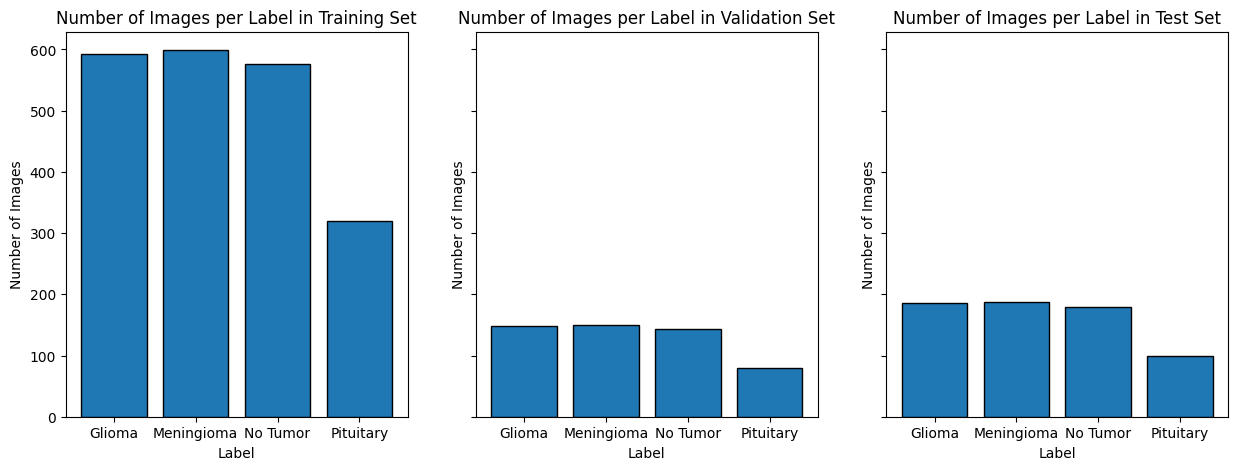

In [65]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

unique_labels, label_counts = np.unique(train[:, 1], return_counts=True)
axes[0].bar(unique_labels, label_counts, edgecolor='black')
axes[0].set_xticks(unique_labels)
axes[0].set_xticklabels(['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Number of Images per Label in Training Set')

unique_labels, label_counts = np.unique(val[:, 1], return_counts=True)
axes[1].bar(unique_labels, label_counts, edgecolor='black')
axes[1].set_xticks(unique_labels)
axes[1].set_xticklabels(['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Number of Images per Label in Validation Set')

unique_labels, label_counts = np.unique(test[:, 1], return_counts=True)
axes[2].bar(unique_labels, label_counts, edgecolor='black')
axes[2].set_xticks(unique_labels)
axes[2].set_xticklabels(['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Number of Images')
axes[2].set_title('Number of Images per Label in Test Set')

# Display the plot
plt.show()

### Save the images under train, test and val folders with the respective labels in the folder name

In [66]:
import os
from PIL import Image

def save_images(data, base_folder):
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    for img_path, label in data:
        label_folder = os.path.join(base_folder, str(label))
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        img = Image.open(img_path)
        img.save(os.path.join(label_folder, os.path.basename(img_path)))

if initialized_data!=True:
    # Save the images for each dataset
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

### Load the images from the folders and perform data augmentation

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,      # Randomly shift images vertically by 20% of the height
    shear_range=0.2,             # Apply shearing transformations
    zoom_range=0.2,              # Randomly zoom in or out by 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill missing pixels after transformations
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    'train',                   
    target_size=(512, 512),     
    batch_size=32,              
    class_mode='categorical'    
)

val_generator = val_datagen.flow_from_directory(
    'val', 
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)



Found 2088 images belonging to 4 classes.
Found 523 images belonging to 4 classes.
Found 653 images belonging to 4 classes.


### Build a CNN model and train it on the images

Epoch 1/2
66/66 [==============================] - ETA: 0s - loss: 1.7952 - accuracy: 0.2807
Epoch 1: val_loss improved from inf to 1.34115, saving model to model.h5


c:\Users\shegg\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 106s 2s/step - loss: 1.7952 - accuracy: 0.2807 - val_loss: 1.3412 - val_accuracy: 0.3346
Epoch 2/2
66/66 [==============================] - ETA: 0s - loss: 1.3244 - accuracy: 0.3851
Epoch 2: val_loss improved from 1.34115 to 1.28285, saving model to model.h5
66/66 [==============================] - 91s 1s/step - loss: 1.3244 - accuracy: 0.3851 - val_loss: 1.2829 - val_accuracy: 0.4512
Best epoch: 2


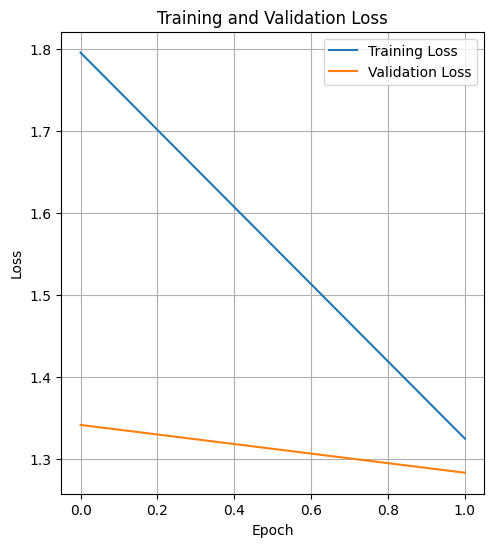

In [48]:
### Build a CNN model and train it on the images
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.h5', save_best_only=True, mode='min', monitor='val_loss', verbose=1)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    verbose=1,
    callbacks=[checkpoint]
)
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f'Best epoch: {best_epoch:d}')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

### Predict using the best model

In [ ]:
model.load_weights('model.h5')

threshold = 0.5

test_generator.reset()
predictions = model.predict(test_generator)

### Evaluate the model

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate metrics
accuracy = np.mean(y_true == y_pred)
precision = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1)
f1 = 2 * precision * recall / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


# Generate a classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices)
print(report)


Accuracy: 0.25
Precision: 0.28
Recall: 0.47
F1 Score: 0.35
              precision    recall  f1-score   support

           0       0.33      0.16      0.21       185
           1       0.28      0.47      0.35       188
           2       0.25      0.11      0.15       180
           3       0.14      0.24      0.18       100

    accuracy                           0.25       653
   macro avg       0.25      0.24      0.22       653
weighted avg       0.26      0.25      0.23       653



### Evaluate the model on the models ability to detect tumor or no tumor

Accuracy: 0.66
Precision: 0.84
Recall: 0.74
F1 Score: 0.79


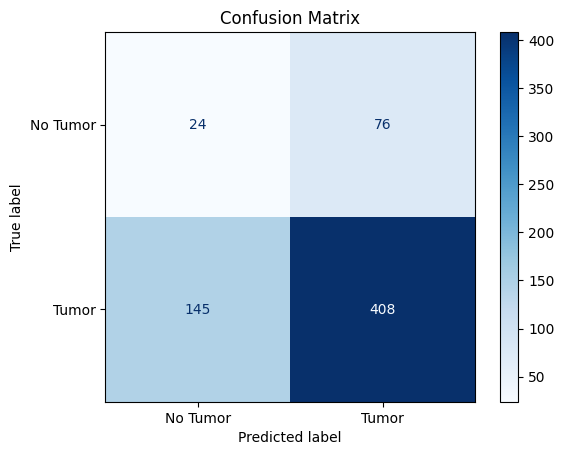

In [62]:
# Calculate metrics for thast groups all the tumor classes together and compares them to the no_tumor class
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay

y_true_grouped = np.where(y_true == 3, 0, 1)

y_pred_grouped = np.where(y_pred == 3, 0, 1)

# Calculate metrics
accuracy = np.mean(y_true_grouped == y_pred_grouped)
precision = precision_score(y_true_grouped, y_pred_grouped)
recall = recall_score(y_true_grouped, y_pred_grouped)
f1 = f1_score(y_true_grouped, y_pred_grouped)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


# Plot the confusion matrix
cm = confusion_matrix(y_true_grouped, y_pred_grouped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()